In [1]:
# Place all necessary imports here
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image
import cv2
from pytictoc import TicToc
from scipy import signal

In [2]:
# Function that converts a video into its separate image frames
# and returns it as an array of image frames of both colour and gray
def processVideo(videoName):
    # Extracting video metadata
    video = cv2.VideoCapture(videoName)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = int(total_frames/fps)
    width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))   
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    colour_frames = np.zeros([total_frames, height, width, 3], dtype = int)
    gray_frames = np.zeros([total_frames, height, width], dtype = int)
    
    # Printing video metadata
    print("FPS:", fps)
    print("Total frames:", total_frames)
    print("Duration:", duration, "seconds")
    print("Frame width:", width, "pixels")
    print("Frame height:", height, "pixels")
    
    # Loading image frames into output array and immediately converting to gray scale
    for frame_num in range(total_frames):
        # Getting frame at frame_num
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = video.read() 
        # Storing image into output arrays
        colour_frames[frame_num] = frame
        gray_frames[frame_num] = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
          
    return colour_frames, gray_frames

In [3]:
# Writing 1st frame of the video data to text file
def write2textFile(img, colour):
    total_frames = 448
    height = 226 
    width = 400
    
    # Writing colour frame to file
    if(colour == 'rgb'):
        with open("colourFrame.txt", "w") as c_file:
            for y in range(height):              # Iterates over image pixel rows
                for x in range(width):           # Iterates over image pixel columns
                    # Writing RGB as one value and converting to HEX
                    pixel = format(img[y][x][0], '02x') + format(colour_frames[frame_num][y][x][1], '02x') + format(colour_frames[frame_num][y][x][2], '02x')
                    c_file.write(pixel)
                    c_file.write('\n')    
        c_file.close()
     
    # Writing grayscale frame to file
    if(colour == 'gray'):
        with open("grayFrame.txt", "w") as g_file:
            for y in range(height):              # Iterates over image pixel rows
                for x in range(width):           # Iterates over image pixel columns
                    pixel = format(img[y][x], '02x')
                    g_file.write(pixel)
                    g_file.write('\n')    
        g_file.close()   
        
    
        
    print("Frame data is saved to file")
    

In [4]:
def text2array(file, img):
    frameSize = img.shape[0]*img.shape[1]
    with open(file, "r") as inFile:
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                temp = inFile.readline()
                pixel = temp.split('\\n')
                img[y][x] = int(pixel[0], 16)
    return img        
                

In [5]:
# A function that applies a median noise filter over the 
# grayscaled image and returns the filtered image as a 2D array 

# Uses a 3x3 kernel over the image during the filtering process
def median_filter(img):
    # initializing the output image arrays
    output = np.zeros_like(img)  
    for i in range(1, img.shape[0] - 1): # loop for the x-axis
        for j in range(1, img.shape[1] - 1): # loop for the y-axis
            # placing the pixels into a 1D kernal using ravel  
            kernel = np.ravel(img[i - 1: i + 2, j - 1: j + 2])  
            # sorting the kernel array then taking the 5th value 
            # which is the median value index of the kernal (3x3 => 1x9)
            # then placing result into the output image array
            output[i][j] = np.sort(kernel)[4]
    return output     

In [6]:
# A functions that detects the initial edges of a 
# given image frame and returns a 2D array of the image

# The values of the output array represent the magnitudes 
# of the gradients computed within the image

def sobel_operator(img):
    # initializing the output array
    output = np.zeros_like(img)

    # defining the sobel x & y kernels
    xsobel = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])

    ysobel = np.array([[-1, -2, 1],
                         [ 0,  0, 0],
                         [ 1,  2, 1]])

    for i in range(img.shape[0] - 2): # loop for x-axis
        for j in range(img.shape[1] - 2): # loop for y-axis
            gx = np.sum(np.multiply(xsobel, img[i:i + 3, j:j + 3])) # x derivative
            gy = np.sum(np.multiply(ysobel, img[i:i + 3, j:j + 3])) # y derivative
            # storing the magnitude of the calculated gradients 
            # and storing it into the output image array
            output[i + 1, j + 1] = np.sqrt((gx ** 2) + (gy ** 2)) 

    return output.astype(int) # forcing it to int type

In [7]:
""""
Implementing all the functions from above to convert 
an inputted video into and outputs a video displaying
all the edges that were detected
"""
# Loading in video and converting it to its separate image frames
colour_frames, gray_frames = processVideo("sample_video.mp4")

FPS: 60
Total frames: 448
Duration: 7 seconds
Frame width: 400 pixels
Frame height: 226 pixels


In [8]:
# Writing first grayscale frame of the video into text files
write2textFile(gray_frames[0], 'gray')

Frame data is saved to file


In [9]:
# Instantiating instance of TicToc class
t = TicToc()

In [10]:
# Reading in frame data from text file and storing it into an array
t.tic()
img = np.zeros([226, 400], dtype = int)
img = text2array("grayFrame.txt", img)
t.toc('Loading in image data took')

Loading in image data took 0.139465 seconds.


In [11]:
# Applying median filter over image frame
t.tic()
med = median_filter(img)
t.toc('Median filtering took')

Median filtering took 1.098339 seconds.


In [12]:
# Applying sobel operator over image frame
t.tic()
sob = sobel_operator(med)
t.toc('Finding edges took')

Finding edges took 2.339167 seconds.


In [13]:
matplotlib.image.imsave('output.png', sob)

In [14]:
# Comparing the outout image frames between the Python and Verilog implementations

# Loading in data from Verilog image frame
v_img = np.zeros_like(sob)
v_img = text2array("outGrayFrame.txt", v_img)

In [15]:
matplotlib.image.imsave('voutput.png', v_img)

In [16]:
# Calculating the correlation between
corr = signal.correlate2d(sob, v_img)
print("The correlation between these 2 images is: ", corr)

The correlation between these 2 images is:  [[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 ...
 [     0      0      0 ... 254235 168555      0]
 [     0      0      0 ... 262905 176205      0]
 [     0      0      0 ...      0      0      0]]


In [17]:
print(np.mean(np.ravel(corr)))

29392797.50483559


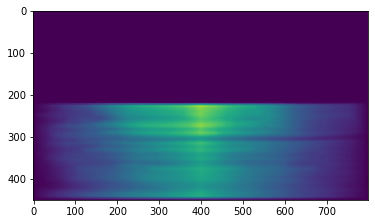

In [18]:
plt.imshow(corr)

In [19]:
matplotlib.image.imsave('crossCorr.png', corr)